In [22]:
import numpy as np
import pickle
import Tkinter as tk
%matplotlib inline
import cv2

In [186]:
with open('single_lane_recording.pkl') as f:
    source = pickle.load(f)
    

In [24]:
def get_inverse_perspective_transform(): 
    return Controller.get_perspective_transform(inverse=True)


def get_perspective_transform(inverse=False):        
    p1 = (232, 380) # top left
    p2 = (360, 380) # top right
    p3 = (206, 414) # bottom left
    p4 = (383, 414) # bottom right

    pts1 = np.float32([list(p1),list(p2),list(p3),list(p4)])
    output_width = 100
    output_height = 35
    dx=289
    dy=585
    pts2 = np.float32([[dx,dy],[dx+output_width,dy],[dx,dy+output_height],[dx+output_width,dy+output_height]])
    if inverse:
        M = cv2.getPerspectiveTransform(pts2,pts1)
    else:
        M = cv2.getPerspectiveTransform(pts1,pts2)
    return M


def transform_anchor_points(points, M):
    points = np.array(points, dtype=np.float32)
    transformed = cv2.perspectiveTransform(points[None, :, :], M)
    return transformed.tolist()[0]


def compute_topdown_image(image_filename, transformation_matrix, transformation_size):
    img = cv2.imread(image_filename)
    img = cv2.cvtColor(img, cv2.cv.CV_BGR2RGB)
    dst = cv2.warpPerspective(img, transformation_matrix, (transformation_size , transformation_size))
    dst = cv2.cvtColor(dst, cv2.cv.CV_BGR2RGB)
    dst_img = Image.fromarray(dst)
    return dst_img

In [187]:
source

{'front_to_topdown_transformation': array([[ -2.38295486e-01,  -1.17472666e+00,   4.13530418e+02],
        [  5.08482145e-14,  -2.44322960e+00,   7.49991590e+02],
        [  8.15320034e-17,  -3.43425848e-03,   1.00000000e+00]]),
 'image_files': ['images/frame0000.jpg',
  'images/frame0001.jpg',
  'images/frame0002.jpg',
  'images/frame0003.jpg',
  'images/frame0004.jpg',
  'images/frame0005.jpg',
  'images/frame0006.jpg',
  'images/frame0007.jpg',
  'images/frame0008.jpg',
  'images/frame0009.jpg',
  'images/frame0010.jpg',
  'images/frame0011.jpg',
  'images/frame0012.jpg',
  'images/frame0013.jpg',
  'images/frame0014.jpg',
  'images/frame0015.jpg',
  'images/frame0016.jpg',
  'images/frame0017.jpg',
  'images/frame0018.jpg',
  'images/frame0019.jpg',
  'images/frame0020.jpg',
  'images/frame0021.jpg',
  'images/frame0022.jpg',
  'images/frame0023.jpg',
  'images/frame0024.jpg',
  'images/frame0025.jpg',
  'images/frame0026.jpg',
  'images/frame0027.jpg',
  'images/frame0028.jpg',
  

[[245, 94], [247, 291], [251, 653]]
[[284.7004699707031, 309.3702697753906], [278.33966064453125, 317.8919372558594], [155.72532653808594, 483.3656921386719]]
[[284.0000305175781, 94.00016021728516], [286.0, 290.9998474121094], [290.0, 653.0]]


In [26]:
# for image_file in source['image_files']:
#     frame_data = source['lanes'][image_file]
#     for lane_id, lane_data in frame_data.iteritems():
#         anchor_points1 = lane_data['anchor_points']
#         anchor_points2 = transform_anchor_points(anchor_points1, to_front)
#         anchor_points3 = transform_anchor_points(anchor_points2, to_topdown_center)
#         lane_data['anchor_points'] = anchor_points3
    
        

In [61]:
import copy

def calculate_affordances(frame_data, image_center, front=False, perspective_transform=None, scale=1.0):
    splines = []
    
    for lane_data in frame_data.values():
        anchor_points = lane_data['anchor_points']
        if front and perspective_transform is not None:
            anchor_points = transform_anchor_points(anchor_points, perspective_transform)
        splines.append(copy.deepcopy(anchor_points))

    # splines sorted by blue X value
    splines = sorted(splines, key=lambda spline: spline[2][0])
    for spline in splines:
        for i in range(len(spline)):
            spline[i][0] = spline[i][0]*scale
            spline[i][1] = spline[i][1]*scale
    # comput distance from lane x to center of the image
    spline_to_center_distances = []
    for index in range(len(splines)):
        spline = splines[index]
        distance = image_center - spline[2][0]
        spline_to_center_distances.append([index, distance])

    # sort by distance.  If distance is negative (right lane) it is put at the bottom
    closest_left_splines = sorted(spline_to_center_distances, key=lambda x: x[1] if x[1] >=0 else 999999999)
    left_lane1_index = closest_left_splines[0][0]
    left_lane2_index = left_lane1_index - 1
    right_lane1_index = left_lane1_index + 1
    right_lane2_index = right_lane1_index + 1

    displacement_indicies = [left_lane2_index, left_lane1_index, right_lane1_index, right_lane2_index]
    displacements = []
    for displacement_index in displacement_indicies:
        displacements.append(np.abs(spline_to_center_distances[displacement_index][1]))
    
    left_spline = splines[left_lane1_index]
    right_spline = splines[right_lane1_index]
    
    
    middle_anchor_average = ((np.array(left_spline[1]) + np.array(right_spline[1]))/2.0)
    bottom_anchor_average = ((np.array(left_spline[2]) + np.array(right_spline[2]))/2.0)
    
    anchor_diff = bottom_anchor_average - middle_anchor_average
    slope = -anchor_diff[0]/(anchor_diff[1])
    angle = np.arctan(slope)
    displacements.append(slope)
    return displacements

In [ ]:
import copy

def calculate_spline_affordances(frame_data, image_center, front=False, perspective_transform=None, scale=1.0):
    splines = []
    
    for lane_data in frame_data.values():
        anchor_points = lane_data['anchor_points']
        if front and perspective_transform is not None:
            anchor_points = transform_anchor_points(anchor_points, perspective_transform)
        splines.append(copy.deepcopy(anchor_points))

    # splines sorted by blue X value
    splines = sorted(splines, key=lambda spline: spline[2][0])
    for spline in splines:
        for i in range(len(spline)):
            spline[i][0] = spline[i][0]*scale
            spline[i][1] = spline[i][1]*scale
    # comput distance from lane x to center of the image
    spline_to_center_distances = []
    for index in range(len(splines)):
        spline = splines[index]
        distance = image_center - spline[2][0]
        spline_to_center_distances.append([index, distance])

    # sort by distance.  If distance is negative (right lane) it is put at the bottom
    closest_left_splines = sorted(spline_to_center_distances, key=lambda x: x[1] if x[1] >=0 else 999999999)
    left_lane1_index = closest_left_splines[0][0]
    right_lane1_index = left_lane1_index + 1

    left_spline = splines[left_lane1_index]
    right_spline = splines[right_lane1_index]
    
    
    
    anchor_diff = bottom_anchor_average - middle_anchor_average
    slope = -anchor_diff[0]/(anchor_diff[1])
    angle = np.arctan(slope)
    displacements.append(slope)
    return displacements

In [28]:
frame_data =source['lanes']['images/frame0102.jpg']

In [29]:
np.array([2,3.])/np.array([4.,7])

array([ 0.5       ,  0.42857143])

[55.875, 17.625, 19.875, 57.0, -0.040916440602613936]
55.875
[71.625, 251.25, 127.5, 251.25]
17.625
[109.875, 247.5, 127.5, 247.5]
-19.875
[147.375, 243.75, 127.5, 243.75]
-57.0
[184.5, 240.0, 127.5, 240.0]


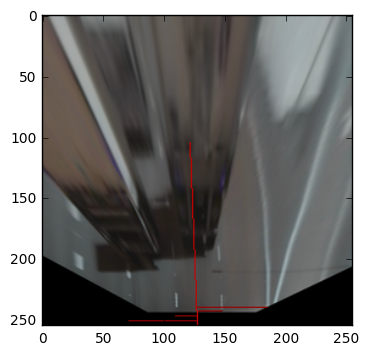

In [63]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import cv2

def display_affordances(source, image_file, resized=None):
    frame_data =source['lanes'][image_file]
    im = compute_topdown_image(image_file, source['front_to_topdown_transformation'], source['transformation_size']) 

     
    scale = 1.0
    size = im.size[0]
    if resized:        
        scale = resized/float(size)
        im = im.resize((resized,resized), Image.ANTIALIAS)
    draw = ImageDraw.Draw(im)
    center_x = size/2.0 * scale
    affordences=calculate_affordances(frame_data, center_x, scale=scale)
    print affordences
    width = int(4 *scale)
    for i in range(len(affordences[:4])):
        y = im.size[0] -((i+1)*(10*scale))
        displacement = (1.0 if i <2 else -1.0)*affordences[i]
        print displacement
        x = center_x-displacement
        print [x, y, center_x, y]
        draw.line([x, y, center_x, y], fill=150, width=width)

    heading_dx = np.tan(affordences[4])*150
    draw.line([center_x, im.size[0], center_x + heading_dx, im.size[0]-150], fill=200, width=int(4*scale))
    imshow(im)

    
display_affordances(source, 'images/frame0599.jpg', resized=255)


In [69]:
import numpy as np
np.array(im.getdata())

array([[97, 84, 78],
       [95, 83, 79],
       [91, 84, 80],
       ..., 
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [165]:
from keras.preprocessing import image
from imagenet_utils import preprocess_input, decode_predictions
import numpy as np
import random
def create_dataset(save_file, images, source, resized=224, shuffle=False, data_max=None, data_min=None):    
    n = len(images)
    map_size = n
    env = lmdb.open(save_file, map_size=map_size)

    images = list(images)
    if shuffle:
        random.shuffle(images)
    image_data = np.zeros((n, resized, resized,3))
    image_affordances = np.zeros((n,5))
    for i in range(len(images)):
        image_file = images[i]
        frame_data =source['lanes'][image_file]
        im = compute_topdown_image(image_file, source['front_to_topdown_transformation'], source['transformation_size']) 
        scale = 1.0
        size = im.size[0]
        if resized:        
            scale = resized/float(size)
            im = im.resize((resized,resized), Image.ANTIALIAS)
        center_x = size/2.0 * scale
        affordances=calculate_affordances(frame_data, center_x, scale=scale)
        x = image.img_to_array(im)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        image_data[i,:,:,:] = x
        image_affordances[i, :] = affordances
    image_affordances, data_min, data_max = normalize_to_range(image_affordances,0.1,0.9, data_max=data_max, data_min=data_min)    
    return images, image_data, image_affordances, data_min, data_max
        
    

In [184]:
train_files = source['image_files'][:900]
test_files = source['image_files'][901:1000]
fields = ['images','image_data', 'targets', 'max', 'min']
train = create_dataset(train_files, source, resized=224, shuffle=True)
test= create_dataset(test_files, source, resized=224,data_max=train[4], data_min=train[3])
data = {
    'train':dict(zip(fields, train)),
    'test':dict(zip(fields, test))
}
    



[ 10.54117647   8.23529412   8.56470588  11.52937155   0.20822759]
[ 10.54117647   8.23529412   8.56470588  11.52937155   0.20822759]


In [185]:
with open('toy_data_1000.pkl', 'w') as f:
    pickle.dump(data, f)

In [53]:
with open('toy_data_1000.pkl') as f:
     data=pickle.load(f)

In [182]:
data = {
    'train':dict(zip(fields, train)),
    'test':dict(zip(fields, test))
}

In [168]:
def normalize_to_range(data,low, high, data_min=None, data_max=None):
    # Normalize to [0, 1]:
    if data_min is None:
        data_min = np.min(data, axis=0)
    if data_max is None:
        data_max = np.max(data, axis=0)
    data_range = data_max-data_min
    print data_range
    data = (data - data_min) / data_range;
    # Then scale to [x,y]:
    target_range = high - low;
    data = (data*target_range) + low;
    return data, data_min, data_max

def unnormalize(data, low, high, data_min, data_max):
    target_range = high - low;
    data = (data -low)/target_range
    data_range = data_max-data_min
    print data_range
    data = (data*data_range) + data_min
    return data

array([[ -2.38295486e-01,  -1.17472666e+00,   4.13530418e+02],
       [  5.08482145e-14,  -2.44322960e+00,   7.49991590e+02],
       [  8.15320034e-17,  -3.43425848e-03,   1.00000000e+00]])